Conduct RFM (recency, frequency, monetary value) analysis on political donors in the UK

In [1]:
#imports
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt


# DATA PROCESSING

In [2]:
#read data
df = pd.read_csv('data/Donations accepted by political parties.csv')
df.shape

/var/folders/9t/ywq9gg3s4zbgn2zw5tfskbv00000gn/T/ipykernel_65752/3107819911.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Donations accepted by political parties.csv')


(65278, 29)

In [3]:

#drop all nans from the columns that we will be using
df = df.dropna(subset=['Value', 'DonorId', 'ReceivedDate'])
df.shape

(62492, 29)

In [4]:
#change received data from string to datetime
df['ReceivedDate'] = pd.to_datetime(df['ReceivedDate'], format='%d/%m/%Y')

#Change monetary value to float for computation
df['Value'] = df['Value'].replace('[\£,]', '', regex=True).astype(float)



In [5]:
#Only consider donations from the last 3 elections so that we do not skew recency values, i.e. consider values from 2015-2019 only. 
# Convert start_date and end_date to datetime format
start_date = pd.to_datetime('2010-05-06') #2010 election date
end_date = pd.to_datetime('2019-12-12')   #2019 election date

# Filter the DataFrame based on date range
df1 = df[(df['ReceivedDate'] >= start_date) & (df['ReceivedDate'] <= end_date)]

Text(0, 0.5, 'Frequency')

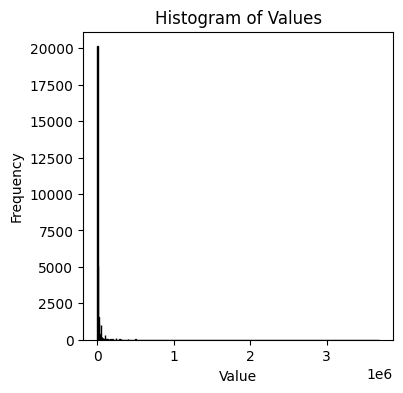

In [6]:
#Hist plots of columns to understand distribution
plt.figure(figsize=(4, 4))  # Optional: specify the figure size
df1['Value'].plot(kind='hist', bins=500, edgecolor='black')

plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')


In [7]:
#There are extereme outliers which will affect the results of our RFM analysis. Therefore we can use the IQR method to remove the outliers.
#Outlers are able Q3 + 1.5*IQR

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df1['Value'].quantile(0.25)
Q3 = df1['Value'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
upper_bound = Q3 + 1.5 * IQR
upper_bound = 1000000  #set manually or remove this to remove outliers using IQR method

df1 = df1[(df1['Value'] <= upper_bound)]

Text(0, 0.5, 'Frequency')

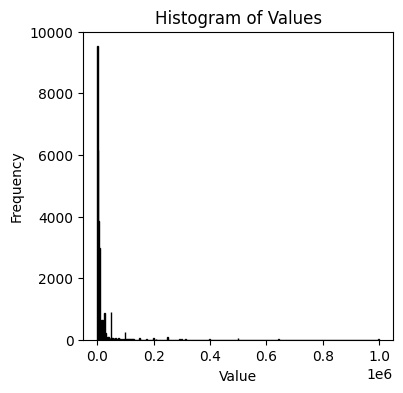

In [8]:
#Re-plot hist to ensure outliers are removed
plt.figure(figsize=(4, 4))  # Optional: specify the figure size
df1['Value'].plot(kind='hist', bins=500, edgecolor='black')

plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# RFM ANALYSIS 

In [9]:
#Compute recency values
recency_df = df1.groupby(by='DonorId', as_index=False)['ReceivedDate'].max()
recency_df.columns = ['DonorId', 'LastDonationDate']
recent_date = recency_df['LastDonationDate'].max()
recency_df['Recency'] = recency_df['LastDonationDate'].apply(
    lambda x: (recent_date - x).days)
recency_df.head

<bound method NDFrame.head of        DonorId LastDonationDate  Recency
0          3.0       2015-02-18     1657
1          4.0       2010-12-31     3167
2          7.0       2017-05-08      847
3          8.0       2017-05-18      837
4          9.0       2019-04-04      151
...        ...              ...      ...
11502  87472.0       2019-07-19       45
11503  87473.0       2019-08-05       28
11504  87478.0       2018-11-01      305
11505  87480.0       2017-03-13      903
11506  87482.0       2014-02-06     2034

[11507 rows x 3 columns]>

In [10]:
#Compute Frequency 
frequency_df = df1.drop_duplicates().groupby(
    by=['DonorId'], as_index=False)['ReceivedDate'].count()
frequency_df.columns = ['DonorId', 'Frequency']
frequency_df.head

<bound method NDFrame.head of        DonorId  Frequency
0          3.0          1
1          4.0          2
2          7.0          4
3          8.0          2
4          9.0          7
...        ...        ...
11502  87472.0          1
11503  87473.0          1
11504  87478.0          2
11505  87480.0          1
11506  87482.0          1

[11507 rows x 2 columns]>

In [11]:
#Compute Monetary Value
monetary_df = df1.groupby(by='DonorId', as_index=False)['Value'].sum()
monetary_df.columns = ['DonorId', 'Monetary']
monetary_df.head

<bound method NDFrame.head of        DonorId   Monetary
0          3.0    1625.00
1          4.0    4000.00
2          7.0   22350.00
3          8.0    6300.00
4          9.0   96388.32
...        ...        ...
11502  87472.0   35000.00
11503  87473.0    4000.00
11504  87478.0    3529.41
11505  87480.0  157350.07
11506  87482.0   50000.00

[11507 rows x 2 columns]>

In [12]:
#merge R, F & M values into one df
rfm = pd.merge(recency_df, frequency_df, on='DonorId')
rfm = pd.merge(rfm, monetary_df, on='DonorId')

In [13]:
# Define scoring criteria for each RFM value
recency_scores = [5, 4, 3, 2, 1]
frequency_scores = [1, 2, 3, 4, 5]
monetary_scores = [1, 2, 3, 4, 5]
recency_weight = 1
frequency_weight = 1
monetary_weight = 1

In [14]:
# Calculate RFM scores
rfm['RecencyScore'] = pd.cut(rfm['Recency'], bins=len(recency_scores), labels=recency_scores)
rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=len(frequency_scores), labels=frequency_scores)
rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=len(monetary_scores), labels=monetary_scores)
# Convert RFM scores to numeric type
rfm[['RecencyScore', 'FrequencyScore', 'MonetaryScore']] = rfm[['RecencyScore', 'FrequencyScore', 'MonetaryScore']].astype(int)

In [15]:
#Calculate RFM score
rfm['RFM_Score'] = recency_weight*rfm['RecencyScore'] + frequency_weight*rfm['FrequencyScore'] + monetary_weight*rfm['MonetaryScore']

#Segment donors based on score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
rfm['RFM_Segment'] = pd.qcut(rfm['RFM_Score'], q=3, labels=segment_labels)

In [16]:
# Create a new column for RFM Customer Segments
rfm['RFM_Customer_Segment'] = ''
# Assign RFM segments based on the RFM score
rfm.loc[rfm['RFM_Score'] >= 9, 'RFM_Customer_Segment'] = 'Champions'
rfm.loc[(rfm['RFM_Score'] >= 6) & (rfm['RFM_Score'] < 9), 'RFM_Customer_Segment'] = 'Potential Loyalists'
rfm.loc[(rfm['RFM_Score'] >= 5) & (rfm['RFM_Score'] < 6), 'RFM_Customer_Segment'] = 'At Risk Customers'
rfm.loc[(rfm['RFM_Score'] >= 4) & (rfm['RFM_Score'] < 5), 'RFM_Customer_Segment'] = "Can't Lose"
rfm.loc[(rfm['RFM_Score'] >= 3) & (rfm['RFM_Score'] < 4), 'RFM_Customer_Segment'] = "Lost"

In [17]:
rfm

,DonorId,LastDonationDate,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,RFM_Segment,RFM_Customer_Segment
0,3.0,2015-02-18,1657,1,1625.00,3,1,1,5,Low-Value,At Risk Customers
1,4.0,2010-12-31,3167,2,4000.00,1,1,1,3,Low-Value,Lost
2,7.0,2017-05-08,847,4,22350.00,4,1,1,6,Mid-Value,Potential Loyalists
3,8.0,2017-05-18,837,2,6300.00,4,1,1,6,Mid-Value,Potential Loyalists
4,9.0,2019-04-04,151,7,96388.32,5,1,1,7,High-Value,Potential Loyalists
...,...,...,...,...,...,...,...,...,...,...,...
11502,87472.0,2019-07-19,45,1,35000.00,5,1,1,7,High-Value,Potential Loyalists
11503,87473.0,2019-08-05,28,1,4000.00,5,1,1,7,High-Value,Potential Loyalists
11504,87478.0,2018-11-01,305,2,3529.41,5,1,1,7,High-Value,Potential Loyalists
11505,87480.0,2017-03-13,903,1,157350.07,4,1,1,6,Mid-Value,Potential Loyalists


In [18]:
#export data to output file
rfm.to_excel('output/output.xlsx', index=False)